In [1]:
import numpy as np
import pandas as pd

In [2]:
identifiers = pd.read_csv(r'C:\Users\User\Desktop\FluxCT\FluxCT_AutoClean\batch_code\example_code_and_plots\test_tic_list.csv') 
identifiers = list(identifiers['id'])
print('There are ' + str(len(identifiers)) + ' stars in the sample.') 

There are 4 stars in the sample.


In [146]:
identifiers

['TIC 25063215', 'TIC 25063281', 'TIC 25063296', 'TIC 25063656']

In [3]:
# Import modules
import time 
import pandas as pd  
from lightkurve import search_targetpixelfile
from astropy.wcs import WCS
import matplotlib.pyplot as plt
from astropy.io import fits 
import numpy as np
from astroquery.gaia import Gaia
from astropy.coordinates import SkyCoord
import astropy.units as u
import math
from ast import literal_eval
import ssl
import lightkurve
import os

try:
     _create_unverified_https_context = ssl._create_unverified_context
except AttributeError:
    # Legacy Python that doesn't verify HTTPS certificates by default,
    pass
else:
    # Handle target environment that doesn't support HTTPS verification,
    ssl._create_default_https_context = _create_unverified_https_context

# Paths and files 
code_file_path = r"C:\Users\User\Desktop\FluxCT\FluxCT_AutoClean\batch_code\example_code_and_plots/"
plot_path = r"C:\Users\User\Desktop\FluxCT\FluxCT_AutoClean\batch_code\example_code_and_plots/"
identifiers = pd.read_csv(code_file_path + 'test_tic_list.csv') # USER INPUT - TESS ID list  


In [4]:
identifiers = list(identifiers['id'])
print(identifiers)

print('There are ' + str(len(identifiers)) + ' stars in the sample.') 

['TIC 25063215', 'TIC 25063281', 'TIC 25063296', 'TIC 25063656']
There are 4 stars in the sample.


In [5]:
tess_list = []
gaia_source_list = []
ra_list = []
dec_list = []
g_mag_list = []
ruwe_list = []
flux_list = []
not_found = []
a = 0

inputs = "TIC 25063656"
tess = inputs[4:]
print('\n********** TESS ' + str(tess) + ' – Star Number ' + str(a) + ' **********') 
tpf = lightkurve.search_tesscut(inputs).download(cutout_size=11)
print("tpf is ",tpf)
tpf_one = tpf[0]
tpf_one.to_fits(plot_path + 'tess_' + str(tess) + '_fits.fits',overwrite=True)

# Finding tpa
array = tpf_one.pipeline_mask 
print("pipe line mask array is",array)

# Finding the count of each pixel in the rows and columns of the mask. 
row_count = np.count_nonzero(array, axis=1)
col_count = np.count_nonzero(array, axis=0) 

# Columns = col are counting the x coordinate from left to right. 
# This is the lower limit in pixel number for the left hand side of the array
# By adding 1 to the result I am removing the index to 0.
count_x = 0
if col_count[0] != 0:
    count_x = 0
else:
    for i in range(len(col_count)):
        if col_count[i] == 0:
            count_x = i
        else:
            count_x = count_x + 1
            break
    
# Rows are counting the y coordinate from bottom to top.
# This is the lower limit in pixel number for the bottom of the array
# By adding 1 to the result I am removing the index to 0.
count_y = 0
if row_count[0] != 0:
    count_y = 0
else:
    for j in range(len(row_count)):
        if row_count[j] == 0:
            count_y = j 
        else:
            count_y = count_y + 1
            break

# Finding the top right pixel
array_2  = array[np.ix_(~np.all(array == False, axis=1), ~np.all(array == False, axis=0))]
tr_y = array_2.shape[0]  
tr_x = array_2.shape[1]  

# Top left pixel position 
tl_x = count_x - 0.5
tl_y = count_y + tr_y - 1 + 0.5

# Bottom right pixel position 
br_x = count_x + tr_x - 1 + 0.5
br_y = count_y - 0.5

# Bottom left pixel position
# Starts from the first pixel with a non-zero value so only include count_x and count_y 
bl_x = count_x - 0.5
bl_y = count_y - 0.5

# Top right pixel position
# Already calaculated these so just add the 0.5
tr_x = count_x + tr_x - 1 + 0.5
tr_y = count_y + tr_y - 1 + 0.5 

# Pulling image to plot
tpf_data = fits.open(plot_path + 'tess_' + str(tess) + '_fits.fits')
image = tpf_data[1].data
image = image['FLUX'][0]
wcs = WCS(tpf_data[2].header)

# Finding the corners of the aperture mask
tl = tpf_one.wcs.pixel_to_world(tl_x, tl_y)
tr = tpf_one.wcs.pixel_to_world(tr_x, tr_y)
bl = tpf_one.wcs.pixel_to_world(bl_x, bl_y)
br = tpf_one.wcs.pixel_to_world(br_x, br_y)

# Converting the corners of the aperture mask to coordinates for Gaia
top_left = wcs.world_to_pixel(tl)
top_right = wcs.world_to_pixel(tr)
bottom_left = wcs.world_to_pixel(bl)
bottom_right = wcs.world_to_pixel(br)

# Coordinates to search in Gaia 
tr_ra = tr.ra.deg
tr_dec = tr.dec.deg
tl_ra = tl.ra.deg
tl_dec = tl.dec.deg
br_ra = br.ra.deg
br_dec = br.dec.deg
bl_ra = bl.ra.deg
bl_dec = bl.dec.deg

# Creating Gaia call
polygon = str(br_ra) + ', ' + str(br_dec) + ', ' + str(bl_ra) + ', ' + str(bl_dec) + ', ' + str(tl_ra) + ', ' + str(tl_dec) + ', ' + str(tr_ra) + ', ' + str(tr_dec)
columns = 'source_id, ra, dec, phot_g_mean_mag, ruwe, phot_g_mean_flux'
polygon_top10query_base = """SELECT
{columns}
FROM gaiaedr3.gaia_source
WHERE 1=CONTAINS(
        POINT(ra, dec), 
        POLYGON({polygon}))
"""

# Querying Gaia
polygon_top10query = polygon_top10query_base.format(columns=columns, 
                        polygon=polygon)

polygon_top10query_job = Gaia.launch_job_async(polygon_top10query)

polygon_top10query_results = polygon_top10query_job.get_results()
print("polygonresults",polygon_top10query_results)




********** TESS 25063656 – Star Number 0 **********


C:\Users\User\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\lightkurve\search.py:423: LightkurveWarning: Warning: 35 files available to download. Only the first file has been downloaded. Please use `download_all()` or specify additional criteria (e.g. quarter, campaign, or sector) to limit your search.
  warnings.warn(


tpf is  TessTargetPixelFile(TICID: TIC 25063656)
pipe line mask array is [[False False False False False False False False False False False]
 [False False False False False False False False False False False]
 [False False False False False False False False False False False]
 [False False False False False False False False False False False]
 [False False False False False False False False False False False]
 [False False False False False False False False False False False]
 [False False False False False False False False False False False]
 [False False False False False False False False False False False]
 [False False False False False False False False False False False]
 [False False False False False False False False False False False]
 [False False False False False False False False False False False]]
INFO: Query finished. [astroquery.utils.tap.core]
polygonresults source_id  ra dec phot_g_mean_mag ruwe phot_g_mean_flux
          deg deg       mag              elect

In [60]:
tpf.cadenceno

array([   0,    1,    2, ..., 1264, 1265, 1266])

In [8]:
tpf_one.

<Quantity [[[  92.725044,   90.18147 ,   94.16656 ,   89.58489 ,
               85.394554,   84.74539 ,   84.51878 ,   84.18695 ,
               83.818565,   91.04956 ,  101.99951 ],
            [  90.73316 ,   89.00646 ,  109.511665,   99.14899 ,
               87.42157 ,   86.01733 ,   84.79169 ,   84.28774 ,
               84.27006 ,   85.13095 ,   90.3322  ],
            [ 102.13493 ,   88.50744 ,   98.80393 ,   93.285774,
               88.89373 ,   92.40165 ,   89.98473 ,   88.85626 ,
               87.52999 ,   88.66387 ,   88.80123 ],
            [ 127.68274 ,   90.54535 ,   87.58991 ,   89.058014,
               95.20447 ,  124.028076,  112.40412 ,  101.077354,
               95.422966,   92.26272 ,   88.1353  ],
            [ 104.74072 ,   89.62899 ,   86.82919 ,   90.54025 ,
              113.69116 ,  322.1818  ,  268.9381  ,  132.5105  ,
              102.22441 ,   92.30645 ,   89.25835 ],
            [  87.267494,   86.30775 ,   85.89991 ,   92.87017 ,
              127.89

In [18]:
sr = lightkurve.search_lightcurve("TIC 25063656", author="tasoc",)

In [21]:
sr

#,mission,year,author,exptime,target_name,distance
,,,,s,,arcsec
0,TESS Sector 01,2018,TASOC,1800,25063656,0.0
1,TESS Sector 01,2018,TASOC,1800,25063656,0.0
2,TESS Sector 02,2018,TASOC,1800,25063656,0.0
3,TESS Sector 02,2018,TASOC,1800,25063656,0.0
4,TESS Sector 03,2018,TASOC,1800,25063656,0.0
5,TESS Sector 03,2018,TASOC,1800,25063656,0.0
6,TESS Sector 04,2018,TASOC,120,25063656,0.0
7,TESS Sector 04,2018,TASOC,1800,25063656,0.0
8,TESS Sector 04,2018,TASOC,1800,25063656,0.0


In [73]:
sr1 = sr[::2]  # each target has both a "CBV" and "ENS" light curve for each sector. 
                       # The TPF and aperture are the same for both, so you only need one.

sr2 = sr1.download_all(download_dir=r"C:\Users\User\Desktop\FluxCT\FluxCT_AutoClean\TASOC2\.") # Defaults to ~/.lightkurve-cache, but I prefer choosing the directory.

In [16]:
tess_test = fits.open(r"C:\Users\User\Desktop\FluxCT\FluxCT_AutoClean\TASOC2\mastDownload\HLSP\hlsp_tasoc_tess_ffi_tic00025063656-s0001-cam4-ccd1-c1800_tess_v05\hlsp_tasoc_tess_ffi_tic00025063656-s0001-cam4-ccd1-c1800_tess_v05_cbv-lc.fits")

In [24]:
tpf.cadenceno

array([   0,    1,    2, ..., 1264, 1265, 1266])

In [17]:
tess_test[1].data['CADENCENO']

array([4697, 4698, 4699, ..., 6031, 6032, 6033], dtype='>i4')

In [22]:
len(tess_test[1].data['CADENCENO'])


1282

In [76]:
tasoc_ap = tess_test[3].data
ap = (tasoc_ap & 2).astype(bool)

In [ ]:
r, r2, r3, r4, r5, r6, r7 = do_calculation(kic)

In [114]:
tess_test

[<astropy.io.fits.hdu.image.PrimaryHDU object at 0x000001B4275B3310>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x000001B4275C5210>, <astropy.io.fits.hdu.image.ImageHDU object at 0x000001B427626650>, <astropy.io.fits.hdu.image.ImageHDU object at 0x000001B42759D710>]

In [83]:
ap_size = len(ap)

In [84]:
tpf2 = lightkurve.search_tesscut(inputs).download(cutout_size=ap_size)

C:\Users\User\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\lightkurve\search.py:423: LightkurveWarning: Warning: 35 files available to download. Only the first file has been downloaded. Please use `download_all()` or specify additional criteria (e.g. quarter, campaign, or sector) to limit your search.
  warnings.warn(


In [23]:
tpf.cadenceno

array([   0,    1,    2, ..., 1264, 1265, 1266])

Help on method plot in module lightkurve.targetpixelfile:

plot(ax=None, frame=0, cadenceno=None, bkg=False, column='FLUX', aperture_mask=None, show_colorbar=True, mask_color='red', title=None, style='lightkurve', **kwargs) method of lightkurve.targetpixelfile.TessTargetPixelFile instance
    Plot the pixel data for a single frame (i.e. at a single time).
    
    The time can be specified by frame index number (`frame=0` will show the
    first frame) or absolute cadence number (`cadenceno`).
    
    Parameters
    ----------
    ax : `~matplotlib.axes.Axes`
        A matplotlib axes object to plot into. If no axes is provided,
        a new one will be generated.
    frame : int
        Frame number. The default is 0, i.e. the first frame.
    cadenceno : int, optional
        Alternatively, a cadence number can be provided.
        This argument has priority over frame number.
    bkg : bool
        If True and `column="FLUX"`, background will be added to the pixel values.
    colu

<Axes: title={'center': 'Target ID: TIC 25063656, Cadence: 120'}, xlabel='Pixel Column Number', ylabel='Pixel Row Number'>

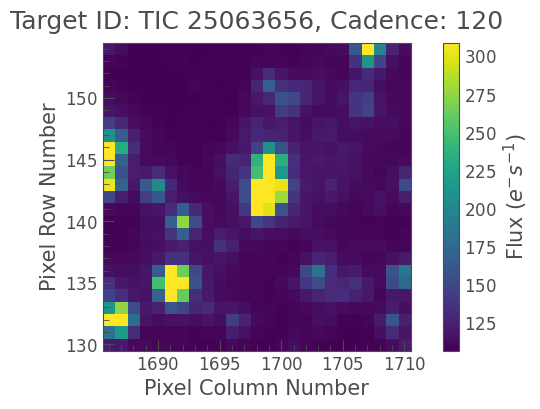

In [115]:
%matplotlib inline


help(tpf2.plot)
tpf2.plot(cadenceno=120)

In [118]:
print(tpf2.hdu[2].data)

[[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 

In [43]:
sr3 = fits.open(r"C:\Users\User\Desktop\FluxCT\FluxCT_AutoClean\TASOC\mastDownload\HLSP\hlsp_tasoc_tess_ffi_tic00025063656-s0001-cam4-ccd1-c1800_tess_v05\hlsp_tasoc_tess_ffi_tic00025063656-s0001-cam4-ccd1-c1800_tess_v05_cbv-lc.fits")
sr4 = fits.open(r"C:\Users\User\Desktop\FluxCT\FluxCT_AutoClean\TASOC\mastDownload\HLSP\hlsp_tasoc_tess_ffi_tic00025063656-s0002-cam4-ccd2-c1800_tess_v05\hlsp_tasoc_tess_ffi_tic00025063656-s0002-cam4-ccd2-c1800_tess_v05_cbv-lc.fits")

In [46]:
print(sr3[3].data)
print(sr4[3].data)
tasoc_ap = sr3[3].data

ap = (tasoc_ap & 2).astype(bool)

[[261 261 261 261 261 261 261 261 261 261 261 261 261 261 261]
 [261 261 261 261 261 261 261 261 261 261 261 261 261 261 261]
 [261 261 261 261 261 261 261 261 261 261 261 261 261 261 261]
 [261 261 261 261 261 261 261 261 261 261 261 261 261 261 261]
 [261 261 261 261 261 261 271 271 271 271 271 271 261 261 261]
 [261 261 261 261 261 271 271 271 271 271 271 271 271 261 261]
 [261 261 261 261 271 271 271 271 271 271 271 271 271 261 261]
 [261 261 261 261 271 271 271 271 271 271 271 271 261 261 261]
 [261 261 261 261 271 271 271 271 271 271 271 271 261 261 261]
 [261 261 261 261 271 271 271 271 271 271 271 271 271 261 261]
 [261 261 261 261 271 271 271 271 271 271 271 271 271 271 261]
 [261 261 261 261 261 271 271 271 271 271 271 271 261 261 261]
 [261 261 261 261 261 271 271 271 271 271 271 261 261 261 261]
 [261 261 261 261 261 261 271 271 271 261 261 261 261 261 261]
 [261 261 261 261 261 261 261 271 261 261 261 261 261 261 261]
 [261 261 261 261 261 261 261 261 261 261 261 261 261 2

In [48]:
print(ap)

[[False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False  True  True  True  True  True  True
  False False False]
 [False False False False False  True  True  True  True  True  True  True
   True False False]
 [False False False False  True  True  True  True  True  True  True  True
   True False False]
 [False False False False  True  True  True  True  True  True  True  True
  False False False]
 [False False False False  True  True  True  True  True  True  True  True
  False False False]
 [False False False False  True  True  True  True  True  True  True  True
   True False False]
 [False False False False  True  True  True  True 

In [5]:
tess_list = []
gaia_source_list = []
ra_list = []
dec_list = []
g_mag_list = []
ruwe_list = []
flux_list = []
not_found = []
a = 0

inputs = "TIC 25063656"
tess = inputs[4:]
print('\n********** TESS ' + str(tess) + ' – Star Number ' + str(a) + ' **********') 
tpf = search_targetpixelfile('TIC ' + str(tess), author='SPOC', cadence='short').download()
tpf_one = tpf[0]
tpf_one.to_fits(plot_path + 'tess_' + str(tess) + '_fits.fits',overwrite=True)

# Finding tpa
array = tpf_one.pipeline_mask 
print("pipe line mask array is",array)

# Finding the count of each pixel in the rows and columns of the mask. 
row_count = np.count_nonzero(array, axis=1)
col_count = np.count_nonzero(array, axis=0) 

# Columns = col are counting the x coordinate from left to right. 
# This is the lower limit in pixel number for the left hand side of the array
# By adding 1 to the result I am removing the index to 0.
count_x = 0
if col_count[0] != 0:
    count_x = 0
else:
    for i in range(len(col_count)):
        if col_count[i] == 0:
            count_x = i
        else:
            count_x = count_x + 1
            break
    
# Rows are counting the y coordinate from bottom to top.
# This is the lower limit in pixel number for the bottom of the array
# By adding 1 to the result I am removing the index to 0.
count_y = 0
if row_count[0] != 0:
    count_y = 0
else:
    for j in range(len(row_count)):
        if row_count[j] == 0:
            count_y = j 
        else:
            count_y = count_y + 1
            break

# Finding the top right pixel
array_2  = array[np.ix_(~np.all(array == False, axis=1), ~np.all(array == False, axis=0))]
tr_y = array_2.shape[0]  
tr_x = array_2.shape[1]  

# Top left pixel position 
tl_x = count_x - 0.5
tl_y = count_y + tr_y - 1 + 0.5

# Bottom right pixel position 
br_x = count_x + tr_x - 1 + 0.5
br_y = count_y - 0.5

# Bottom left pixel position
# Starts from the first pixel with a non-zero value so only include count_x and count_y 
bl_x = count_x - 0.5
bl_y = count_y - 0.5

# Top right pixel position
# Already calaculated these so just add the 0.5
tr_x = count_x + tr_x - 1 + 0.5
tr_y = count_y + tr_y - 1 + 0.5 

# Pulling image to plot
tpf_data = fits.open(plot_path + 'tess_' + str(tess) + '_fits.fits')
image = tpf_data[1].data
image = image['FLUX'][0]
wcs = WCS(tpf_data[2].header)

# Finding the corners of the aperture mask
tl = tpf_one.wcs.pixel_to_world(tl_x, tl_y)
tr = tpf_one.wcs.pixel_to_world(tr_x, tr_y)
bl = tpf_one.wcs.pixel_to_world(bl_x, bl_y)
br = tpf_one.wcs.pixel_to_world(br_x, br_y)

# Converting the corners of the aperture mask to coordinates for Gaia
top_left = wcs.world_to_pixel(tl)
top_right = wcs.world_to_pixel(tr)
bottom_left = wcs.world_to_pixel(bl)
bottom_right = wcs.world_to_pixel(br)

# Coordinates to search in Gaia 
tr_ra = tr.ra.deg
tr_dec = tr.dec.deg
tl_ra = tl.ra.deg
tl_dec = tl.dec.deg
br_ra = br.ra.deg
br_dec = br.dec.deg
bl_ra = bl.ra.deg
bl_dec = bl.dec.deg

# Creating Gaia call
polygon = str(br_ra) + ', ' + str(br_dec) + ', ' + str(bl_ra) + ', ' + str(bl_dec) + ', ' + str(tl_ra) + ', ' + str(tl_dec) + ', ' + str(tr_ra) + ', ' + str(tr_dec)
columns = 'source_id, ra, dec, phot_g_mean_mag, ruwe, phot_g_mean_flux'
polygon_top10query_base = """SELECT
{columns}
FROM gaiaedr3.gaia_source
WHERE 1=CONTAINS(
        POINT(ra, dec), 
        POLYGON({polygon}))
"""

# Querying Gaia
polygon_top10query = polygon_top10query_base.format(columns=columns, 
                        polygon=polygon)

polygon_top10query_job = Gaia.launch_job_async(polygon_top10query)

polygon_top10query_results = polygon_top10query_job.get_results()
print("polygonresults",polygon_top10query_results)




********** TESS 25063656 – Star Number 0 **********


C:\Users\User\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\lightkurve\search.py:423: LightkurveWarning: Warning: 2 files available to download. Only the first file has been downloaded. Please use `download_all()` or specify additional criteria (e.g. quarter, campaign, or sector) to limit your search.
  warnings.warn(


PermissionError: [WinError 32] The process cannot access the file because it is being used by another process: 'C:\\Users\\User\\Desktop\\FluxCT\\FluxCT_AutoClean\\batch_code\\example_code_and_plots/tess_25063656_fits.fits'

<Axes: title={'center': 'Target ID: 25063656, Cadence: 132082'}, xlabel='Pixel Column Number', ylabel='Pixel Row Number'>

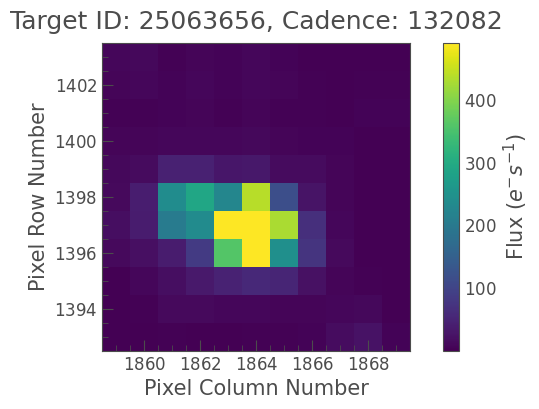

In [3]:
%matplotlib inline

tpf_one.plot()


In [5]:
# Pulling data from Gaia
plot_source = list(polygon_top10query_results['source_id'])
plot_ra = list(polygon_top10query_results['ra'])
plot_dec = list(polygon_top10query_results['dec'])
phot = list(polygon_top10query_results['phot_g_mean_mag'])
ruwe = list(polygon_top10query_results['ruwe']) 
flux = list(polygon_top10query_results['phot_g_mean_flux']) 

[]

In [15]:
# Pulling data from Gaia
plot_source = list(polygon_top10query_results['source_id'])
plot_ra = list(polygon_top10query_results['ra'])
plot_dec = list(polygon_top10query_results['dec'])
phot = list(polygon_top10query_results['phot_g_mean_mag'])
ruwe = list(polygon_top10query_results['ruwe']) 
flux = list(polygon_top10query_results['phot_g_mean_flux']) 

# Initializing lists
plot_source_order = []
plot_ra_order = []
plot_dec_order = []
plot_ruwe_order = []
plot_phot_order = np.sort(phot)
plot_flux_order = []

# Putting the data in the correct order for plotting
for i in range(len(phot)):
    if plot_phot_order[i] in phot:
        index = phot.index(plot_phot_order[i])
        plot_source_order.append(plot_source[index]) 
        plot_ra_order.append(plot_ra[index])
        plot_dec_order.append(plot_dec[index])
        plot_ruwe_order.append(ruwe[index]) 
        plot_flux_order.append(flux[index]) 

# Saving final data lists for the output file
tess_list.append(tess)
ra_list.append(plot_ra_order) 
dec_list.append(plot_dec_order) 
gaia_source_list.append(plot_source_order) 
ruwe_list.append(plot_ruwe_order) 
flux_list.append(plot_flux_order) 


In [1]:
plot_phot_order

NameError: name 'plot_phot_order' is not defined

In [ ]:

# Removing nans from the photometry
plot_phot_order = [-999 if math.isnan(x) else x for x in plot_phot_order]
g_mag_list.append(plot_phot_order) 

# Determining the coordinates of the companions for plotting
companions = SkyCoord(plot_ra_order, plot_dec_order, unit='deg')
print("companians is",companions)
companions_to_plot = wcs.world_to_pixel(companions)

# Making beautiful plot! 
if len(companions_to_plot[0]) == 0: 
    print("not found 5555555555555")
    not_found.append(tess) 
else: 

    # Setting figure
    fig = plt.figure(figsize=(18, 15))
    fig.add_subplot(111, projection = wcs) 

    # Plotting corners and box around TPA 
    top_line_x = [tl_x, tr_x]
    top_line_y = [tl_y, tr_y]
    plt.plot(top_line_x, top_line_y, linewidth=3, color='white')
    bottom_line_x = [bl_x, br_x]
    bottom_line_y = [bl_y, br_y]
    plt.plot(bottom_line_x, bottom_line_y, linewidth=3, color='white')
    left_line_x = [bl_x, tl_x]
    left_line_y = [bl_y, tl_y]
    plt.plot(left_line_x, left_line_y, linewidth=3, color='white')
    right_line_x = [br_x, tr_x]
    right_line_y = [br_y, tr_y]
    plt.plot(right_line_x, right_line_y, linewidth=3, color='white')

    # Plotting magnitudes 
    for i in range(len(phot)):
        try:
            plt.text(companions_to_plot[0][i], companions_to_plot[1][i], str(round(plot_phot_order[i], 3)), color='#dd1c77', fontsize=25)
        except:
            continue

    # Plotting target star and companions
    plt.scatter(companions_to_plot[0][1:], companions_to_plot[1][1:], marker='*', s=2000, color='white', edgecolor='black')
    plt.scatter(companions_to_plot[0][0], companions_to_plot[1][0], marker='*', s=2000, color='pink', edgecolor='black')
    
    # Plotting corner text 
    plt.text(tr_x+0.2, tr_y+0.2, 'RA = ' + str(round(tr.ra.deg, 4)) + '\nDec = ' + str(round(tr.dec.deg, 4)), fontsize=15, backgroundcolor='white') 
    plt.text(tl_x-1.8, tl_y+0.2, 'RA = ' + str(round(tl.ra.deg, 4)) + '\nDec = ' + str(round(tl.dec.deg, 4)), fontsize=15, backgroundcolor='white') 
    plt.text(br_x+0.2, br_y+0.2, 'RA = ' + str(round(br.ra.deg, 4)) + '\nDec = ' + str(round(br.dec.deg, 4)), fontsize=15, backgroundcolor='white') 
    plt.text(bl_x-1.8, bl_y+0.2, 'RA = ' + str(round(bl.ra.deg, 4)) + '\nDec = ' + str(round(bl.dec.deg, 4)), fontsize=15, backgroundcolor='white') 
    
    # Plotting corners
    plt.scatter(tr_x, tr_y, s=200, marker='X', color='white') # Top right
    plt.scatter(tl_x, tl_y, s=200, marker='X', color='white') # Top left
    plt.scatter(br_x, br_y, s=200, marker='X', color='white') # Bottom right
    plt.scatter(bl_x, bl_y, s=200, marker='X', color='white') # Bottom left

    # Setting axes for ticks
    ax = plt.gca()

    # Plotting axes labels, titles, and images
    plt.ylabel('DEC [degrees]', fontsize=20)
    plt.xlabel('RA [hourangle]', fontsize=20)
    plt.imshow(image, origin='lower', cmap='RdPu_r', alpha=1)
    plt.imshow(array, origin='lower',  cmap='binary_r', alpha=0.2)
    plt.title('TESS ' + str(tess), fontsize=20)

    # Setting tick parameters 
    ax.tick_params(axis='x', labelsize=20)
    ax.tick_params(axis='y', labelsize=20)

    # Plotting grid and saving the file
    plt.grid(axis = 'both', color='grey', ls = ':', linewidth=6)
    plt.show()
    plt.savefig(plot_path + str(tess) + 'new.png')
    a = a + 1
    tpf_data.close()
    

In [72]:
"""

# Creating open lists for collecting data
tess_list = []
gaia_source_list = []
ra_list = []
dec_list = []
g_mag_list = []
ruwe_list = []
flux_list = []
not_found = []

# Starting time counter 
t0 = time.time()
a = 0

# Beginning process for i in the list 
for i in identifiers:
   
    # Printing explanatory data  
    tess = i[4:]
    print('\n********** TESS ' + str(tess) + ' – Star Number ' + str(a) + ' **********') 
   
    # Searching for tpf with lightkurve
    tpf = search_targetpixelfile('TIC ' + str(tess), author='SPOC', cadence='short').download()
    print("tpf is ",tpf)
    if tpf ==None:
        print("downloade started, searching for")
        print('TIC ' + str(tess))
        tpf = lightkurve.search_tesscut(i).download()
        print("downloade complete, tpf is now",tpf)
    tpf_one = tpf[0]
    tpf_one.to_fits(plot_path + 'tess_' + str(tess) + '_fits.fits')

    # Finding tpa
    array = tpf_one.pipeline_mask 

    # Finding the count of each pixel in the rows and columns of the mask. 
    row_count = np.count_nonzero(array, axis=1)
    col_count = np.count_nonzero(array, axis=0) 

    # Columns = col are counting the x coordinate from left to right. 
    # This is the lower limit in pixel number for the left hand side of the array
    # By adding 1 to the result I am removing the index to 0.
    count_x = 0
    if col_count[0] != 0:
        count_x = 0
    else:
        for i in range(len(col_count)):
            if col_count[i] == 0:
                count_x = i
            else:
                count_x = count_x + 1
                break
     
    # Rows are counting the y coordinate from bottom to top.
    # This is the lower limit in pixel number for the bottom of the array
    # By adding 1 to the result I am removing the index to 0.
    count_y = 0
    if row_count[0] != 0:
        count_y = 0
    else:
        for j in range(len(row_count)):
            if row_count[j] == 0:
                count_y = j 
            else:
                count_y = count_y + 1
                break
    
    # Finding the top right pixel
    array_2  = array[np.ix_(~np.all(array == False, axis=1), ~np.all(array == False, axis=0))]
    tr_y = array_2.shape[0]  
    tr_x = array_2.shape[1]  

    # Top left pixel position 
    tl_x = count_x - 0.5
    tl_y = count_y + tr_y - 1 + 0.5

    # Bottom right pixel position 
    br_x = count_x + tr_x - 1 + 0.5
    br_y = count_y - 0.5

    # Bottom left pixel position
    # Starts from the first pixel with a non-zero value so only include count_x and count_y 
    bl_x = count_x - 0.5
    bl_y = count_y - 0.5

    # Top right pixel position
    # Already calaculated these so just add the 0.5
    tr_x = count_x + tr_x - 1 + 0.5
    tr_y = count_y + tr_y - 1 + 0.5 

    # Pulling image to plot
    tpf_data = fits.open(plot_path + 'tess_' + str(tess) + '_fits.fits')
    image = tpf_data[1].data
    image = image['FLUX'][0]
    wcs = WCS(tpf_data[2].header)

    # Finding the corners of the aperture mask
    tl = tpf_one.wcs.pixel_to_world(tl_x, tl_y)
    tr = tpf_one.wcs.pixel_to_world(tr_x, tr_y)
    bl = tpf_one.wcs.pixel_to_world(bl_x, bl_y)
    br = tpf_one.wcs.pixel_to_world(br_x, br_y)

    # Converting the corners of the aperture mask to coordinates for Gaia
    top_left = wcs.world_to_pixel(tl)
    top_right = wcs.world_to_pixel(tr)
    bottom_left = wcs.world_to_pixel(bl)
    bottom_right = wcs.world_to_pixel(br)

    # Coordinates to search in Gaia 
    tr_ra = tr.ra.deg
    tr_dec = tr.dec.deg
    tl_ra = tl.ra.deg
    tl_dec = tl.dec.deg
    br_ra = br.ra.deg
    br_dec = br.dec.deg
    bl_ra = bl.ra.deg
    bl_dec = bl.dec.deg

    # Creating Gaia call
    polygon = str(br_ra) + ', ' + str(br_dec) + ', ' + str(bl_ra) + ', ' + str(bl_dec) + ', ' + str(tl_ra) + ', ' + str(tl_dec) + ', ' + str(tr_ra) + ', ' + str(tr_dec)
    columns = 'source_id, ra, dec, phot_g_mean_mag, ruwe, phot_g_mean_flux'
    polygon_top10query_base = """SELECT
    {columns}
    FROM gaiaedr3.gaia_source
    WHERE 1=CONTAINS(
            POINT(ra, dec), 
            POLYGON({polygon}))
    """

    # Querying Gaia
    polygon_top10query = polygon_top10query_base.format(columns=columns, 
                          polygon=polygon)

    polygon_top10query_job = Gaia.launch_job_async(polygon_top10query)

    polygon_top10query_results = polygon_top10query_job.get_results()

    # Pulling data from Gaia
    plot_source = list(polygon_top10query_results['source_id'])
    plot_ra = list(polygon_top10query_results['ra'])
    plot_dec = list(polygon_top10query_results['dec'])
    phot = list(polygon_top10query_results['phot_g_mean_mag'])
    ruwe = list(polygon_top10query_results['ruwe']) 
    flux = list(polygon_top10query_results['phot_g_mean_flux']) 

    # Initializing lists
    plot_source_order = []
    plot_ra_order = []
    plot_dec_order = []
    plot_ruwe_order = []
    plot_phot_order = np.sort(phot)
    plot_flux_order = []

    # Putting the data in the correct order for plotting
    for i in range(len(phot)):
        if plot_phot_order[i] in phot:
            index = phot.index(plot_phot_order[i])
            plot_source_order.append(plot_source[index]) 
            plot_ra_order.append(plot_ra[index])
            plot_dec_order.append(plot_dec[index])
            plot_ruwe_order.append(ruwe[index]) 
            plot_flux_order.append(flux[index]) 

    # Saving final data lists for the output file
    tess_list.append(tess)
    ra_list.append(plot_ra_order) 
    dec_list.append(plot_dec_order) 
    gaia_source_list.append(plot_source_order) 
    ruwe_list.append(plot_ruwe_order) 
    flux_list.append(plot_flux_order) 

    # Removing nans from the photometry
    plot_phot_order = [-999 if math.isnan(x) else x for x in plot_phot_order]
    g_mag_list.append(plot_phot_order) 

    # Determining the coordinates of the companions for plotting
    companions = SkyCoord(plot_ra_order, plot_dec_order, unit='deg')
    companions_to_plot = wcs.world_to_pixel(companions)

    # Making beautiful plot! 
    if len(companions_to_plot[0]) == 0: 
        not_found.append(tess) 
    else: 

        # Setting figure
        fig = plt.figure(figsize=(18, 15))
        fig.add_subplot(111, projection = wcs) 

        # Plotting corners and box around TPA 
        top_line_x = [tl_x, tr_x]
        top_line_y = [tl_y, tr_y]
        plt.plot(top_line_x, top_line_y, linewidth=3, color='white')
        bottom_line_x = [bl_x, br_x]
        bottom_line_y = [bl_y, br_y]
        plt.plot(bottom_line_x, bottom_line_y, linewidth=3, color='white')
        left_line_x = [bl_x, tl_x]
        left_line_y = [bl_y, tl_y]
        plt.plot(left_line_x, left_line_y, linewidth=3, color='white')
        right_line_x = [br_x, tr_x]
        right_line_y = [br_y, tr_y]
        plt.plot(right_line_x, right_line_y, linewidth=3, color='white')

        # Plotting magnitudes 
        for i in range(len(phot)):
            try:
                plt.text(companions_to_plot[0][i], companions_to_plot[1][i], str(round(plot_phot_order[i], 3)), color='#dd1c77', fontsize=25)
            except:
                continue

        # Plotting target star and companions
        plt.scatter(companions_to_plot[0][1:], companions_to_plot[1][1:], marker='*', s=2000, color='white', edgecolor='black')
        plt.scatter(companions_to_plot[0][0], companions_to_plot[1][0], marker='*', s=2000, color='pink', edgecolor='black')
        
        # Plotting corner text 
        plt.text(tr_x+0.2, tr_y+0.2, 'RA = ' + str(round(tr.ra.deg, 4)) + '\nDec = ' + str(round(tr.dec.deg, 4)), fontsize=15, backgroundcolor='white') 
        plt.text(tl_x-1.8, tl_y+0.2, 'RA = ' + str(round(tl.ra.deg, 4)) + '\nDec = ' + str(round(tl.dec.deg, 4)), fontsize=15, backgroundcolor='white') 
        plt.text(br_x+0.2, br_y+0.2, 'RA = ' + str(round(br.ra.deg, 4)) + '\nDec = ' + str(round(br.dec.deg, 4)), fontsize=15, backgroundcolor='white') 
        plt.text(bl_x-1.8, bl_y+0.2, 'RA = ' + str(round(bl.ra.deg, 4)) + '\nDec = ' + str(round(bl.dec.deg, 4)), fontsize=15, backgroundcolor='white') 
       
        # Plotting corners
        plt.scatter(tr_x, tr_y, s=200, marker='X', color='white') # Top right
        plt.scatter(tl_x, tl_y, s=200, marker='X', color='white') # Top left
        plt.scatter(br_x, br_y, s=200, marker='X', color='white') # Bottom right
        plt.scatter(bl_x, bl_y, s=200, marker='X', color='white') # Bottom left

        # Setting axes for ticks
        ax = plt.gca()

        # Plotting axes labels, titles, and images
        plt.ylabel('DEC [degrees]', fontsize=20)
        plt.xlabel('RA [hourangle]', fontsize=20)
        plt.imshow(image, origin='lower', cmap='RdPu_r', alpha=1)
        plt.imshow(array, origin='lower',  cmap='binary_r', alpha=0.2)
        plt.title('TESS ' + str(tess), fontsize=20)

        # Setting tick parameters 
        ax.tick_params(axis='x', labelsize=20)
        ax.tick_params(axis='y', labelsize=20)

        # Plotting grid and saving the file
        plt.grid(axis = 'both', color='grey', ls = ':', linewidth=6)
        plt.savefig(plot_path + str(tess) + '.png')
        a = a + 1
        plt.close()

# Timing code 
t1 = time.time()
total = t1 - t0
print('The total time to create these plots is ' + str(total/60) + ' minutes.') 

# Saving data file
data = zip(tess_list, ra_list, dec_list, gaia_source_list, g_mag_list, ruwe_list, flux_list) 
header = ['tess', 'ra', 'dec', 'gaia_source_list', 'g_mag_list', 'ruwe', 'flux']
df = pd.DataFrame(data=data, columns=header) 
df.to_csv(code_file_path + 'fluxct_data.csv', index=False) 
"""


********** TESS 25063215 – Star Number 0 **********
tpf is  None
downloade started, searching for
TIC 25063215


C:\Users\User\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\lightkurve\search.py:418: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
C:\Users\User\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\lightkurve\search.py:423: LightkurveWarning: Warning: 33 files available to download. Only the first file has been downloaded. Please use `download_all()` or specify additional criteria (e.g. quarter, campaign, or sector) to limit your search.
  warnings.warn(


downloade complete, tpf is now TessTargetPixelFile(TICID: TIC 25063215)
INFO: Query finished. [astroquery.utils.tap.core]

********** TESS 25063281 – Star Number 0 **********


No data found for target "TIC 25063281".
C:\Users\User\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\lightkurve\search.py:418: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(


tpf is  None
downloade started, searching for
TIC 25063281


C:\Users\User\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\lightkurve\search.py:423: LightkurveWarning: Warning: 33 files available to download. Only the first file has been downloaded. Please use `download_all()` or specify additional criteria (e.g. quarter, campaign, or sector) to limit your search.
  warnings.warn(


downloade complete, tpf is now TessTargetPixelFile(TICID: TIC 25063281)
INFO: Query finished. [astroquery.utils.tap.core]

********** TESS 25063296 – Star Number 0 **********


C:\Users\User\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\lightkurve\search.py:423: LightkurveWarning: Warning: 13 files available to download. Only the first file has been downloaded. Please use `download_all()` or specify additional criteria (e.g. quarter, campaign, or sector) to limit your search.
  warnings.warn(


tpf is  TessTargetPixelFile(TICID: 25063296)
INFO: Query finished. [astroquery.utils.tap.core]

********** TESS 25063656 – Star Number 1 **********


C:\Users\User\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\lightkurve\search.py:423: LightkurveWarning: Warning: 2 files available to download. Only the first file has been downloaded. Please use `download_all()` or specify additional criteria (e.g. quarter, campaign, or sector) to limit your search.
  warnings.warn(


tpf is  TessTargetPixelFile(TICID: 25063656)
INFO: Query finished. [astroquery.utils.tap.core]
The total time to create these plots is 2.407857596874237 minutes.
